In [5]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width  = 10, repr.plot.height = 6)
set.seed(1)

# STATS 504
## Week 13: Survival Analysis

In [6]:
d_lung <- survival::lung %>%
  filter(!is.na(ph.ecog)) %>%
  mutate(
    ph.ecog = factor(
      ph.ecog,
      levels = c(0, 1, 2, 3, 4),
      labels = c("Asymptomatic", "Ambulatory", "In bed <50%", "In bed >50%", "Bedridden")),
    ph.ecog = fct_drop(ph.ecog),
    ph.ecog = fct_lump_n(ph.ecog, n = 2, other_level = "Bedridden"),
    sex = factor(sex, levels = c(1, 2), labels = c("Male", "Female")),
    age_bin = cut(age, breaks = c(38, 55, 65, 83)),
    patient_id = row_number()
  )

In [7]:
# install.packages("randomForestSRC")

library(randomForestSRC)

In [8]:
library(randomForestSRC)
rf_mdl <- d_lung %>% mutate(status = status - 1) %>% select(-patient_id) %>% 
    rfsrc(Surv(time, status) ~ ., data = .) 

## Understanding variable importance
- Ensemble methods can be difficult to interpret.
- The authors suggest the following measure of variable importance: 
    - Drop the OOB cases on each tree. Each time the focal predictor $X$ is encountered in a decision rule, pick a random branch.
    - Variable importance is defined as the difference in prediction error between this and the ensemble prediction.

In [40]:
rf_mdl <- d_lung %>% mutate(status = status - 1) %>% 
    select(-patient_id) %>% 
    rfsrc(Surv(time, status) ~ ., data = ., importance = T)
rf_mdl$importance

inst          age          sex      ph.ecog     ph.karno    pat.karno 
-0.008632073  0.013298696  0.024193547  0.074189129  0.011409869  0.092648986 
    meal.cal      wt.loss      age_bin 
 0.008096031  0.007404898  0.002650922

## Prediction Error in Random Survival Forests

- What's an appropriate measure of prediction error for survival data?
- Harrell's $C$: let $M_i$ be the risk (mortality) for patient $i$.
    
    - Concordant pair: $M_i > M_j$ and $T_i < T_j$.
    - Discordant pair: $M_i > M_j$ and $T_i > T_j$.
        
      $$C = \frac{\# \text{ concordant pairs}}{\# \text{ concordant pairs} + \# \text{ discordant pairs}}$$.
- Values:
  - $C$ near 0.5: No better than a coin flip.
  - $C$ near 1: Highly accurate in determining which patient develops the disease first.
  - $C$ near 0: Worse than a coin flip.
- Calculate prediction error as $1 - C$.

### Out-of-Bag Survival

- **OOB Survival**: Estimates the survival function for each observation using trees that did not use this observation during their construction.
- **Unbiased Estimator**: Functions like cross-validation, offering a predictive accuracy measure without requiring a separate test dataset.


### Calculating predicted mortality


$$\bar{M}_i^{\text{OOB}} = \sum_{j=1}^{m}\bar{H}_i^{\text{OOB}}(t_j),
\quad i=1,\ldots,n.$$

## Brier score

- Given $ \hat{S}(t|X) $ estimator of the survival function and $ \hat{G}(t|X) $, an estimator of the censoring probability,
- Uses inverse probability of censoring weights (IPCW)
  $$\hat{BS}(t) = \frac{1}{n} \sum_{i=1}^{n} \left[ \hat{S}^2(t|X_i)I\{T_i \leq t\}\delta_i \hat{G}(T_i^-|X_i) + (1-\hat{S}(t|X_i))^2I\{T_i > t\}\hat{G}(t|X_i) \right] $$.

- Integrated Brier Score (IBS)
  $$ \text{IBS}(\tau) = \frac{1}{\tau}\int_{0}^{\tau} BS(t) dt$$, estimating prediction accuracy over time.
- Lower Brier score values signify better prediction performance.

- Continuous Rank Probability Score (CRPS) is calculated as the IBS divided by time, further evaluating prediction quality.

---

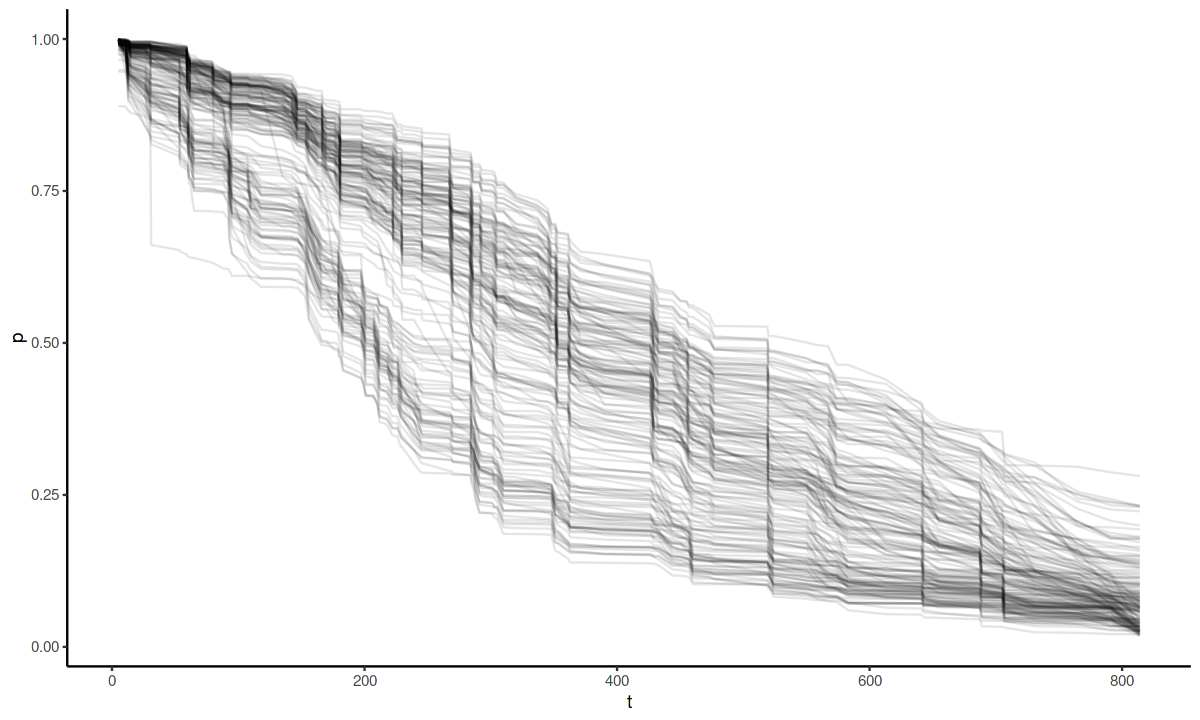

In [9]:
pred_surv <- predict(rf_mdl, type = "survival")
s <- pred_surv$survival  # Matrix
t <- pred_surv$time.interest  # Survival times
colnames(s) <- t
s <- as_tibble(s)
s$id <- 1:nrow(s)
pivot_longer(s, -id, names_to = "t", values_to = "p") %>% mutate(t = as.integer(t)) %>% 
    ggplot(aes(x = t, y = p, group = id)) + geom_line(alpha=0.1)

## Variable importance

- Variable importance measures the impact of each variable on the model's predictive accuracy, specifically in survival predictions.
- Permutation Importance
    - Permute the values of each predictor variable in the OOB data and measuring the decrease in predictive accuracy.
    - The decrease in concordance index or increase in prediction error after permutation indicates variable importance.
- Accessing Variable Importance in `randomForestSRC`
    - After fitting the model with `var.imp = TRUE`, access scores via `rf_model$importance`.
    - Provides a list of variables ranked by their impact on survival outcomes.

inst          age          sex      ph.ecog     ph.karno    pat.karno 
-0.012921149  0.009057374  0.017947360  0.066846560  0.009078176  0.079089483 
    meal.cal      wt.loss      age_bin 
 0.002690752  0.009329544  0.001973167

In [11]:
library(survex)
explainer <- explain(rf_mdl)


Attaching package: ‘survex’


The following object is masked from ‘package:dplyr’:

    explain




Preparation of a new explainer is initiated 
  -> model label       :  rfsrc (  default  ) 
  -> data              :  167  rows  9  cols (  extracted from the model  ) 
  -> target variable   :  167  values ( 120 events and 47 censored , censoring rate = 0.281 ) (  extracted from the model  ) 
  -> times             :  50 unique time points , min = 8 , median survival time = 310 , max = 918 
  -> times             :  (  generated from y as uniformly distributed survival quantiles based on Kaplan-Meier estimator  ) 
  -> predict function  :  sum over the predict_cumulative_hazard_function will be used (  default  ) 
  -> predict survival function  :  stepfun based on predict.rfsrc()$survival will be used (  default  ) 
  -> predict cumulative hazard function  :  stepfun based on predict.rfsrc()$chf will be used (  default  ) 
  -> model_info        :  package randomForestSRC , ver. 3.2.3 , task survival (  default  ) 
  A new explainer has been created!  


In [12]:
m_parts <- model_parts(explainer)

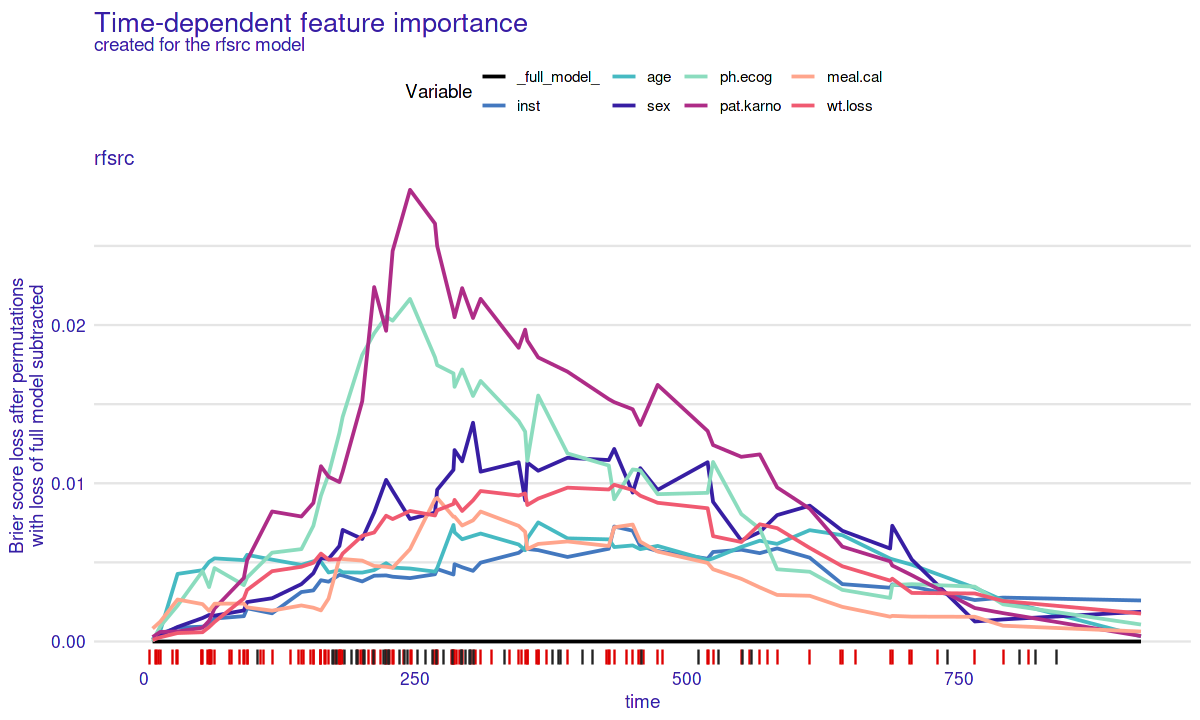

In [13]:
plot(m_parts)

### Local explanations
- Explains the models predictions for a single observation.
- LIME (Local Interpretable Model-agnostic Explanations):
    1. Choose a specific prediction to explain.
    2. Generate variations by altering features of the selected instance.
    3. Use ML model to predict on the perturbed dataset.
    4. Assign weights based on proximity to the original instance.
    5. Train a simple model (e.g., linear model) on the perturbed data, targeting the original model's predictions.
    6. Use the simple model to interpret how features influence the specific prediction.
- SurvLIME: uses a CoxPH model as the "simple model"


In [14]:
patient <- d_lung[4,]
surv_lime <- predict_parts(explainer, patient, type = "survlime")

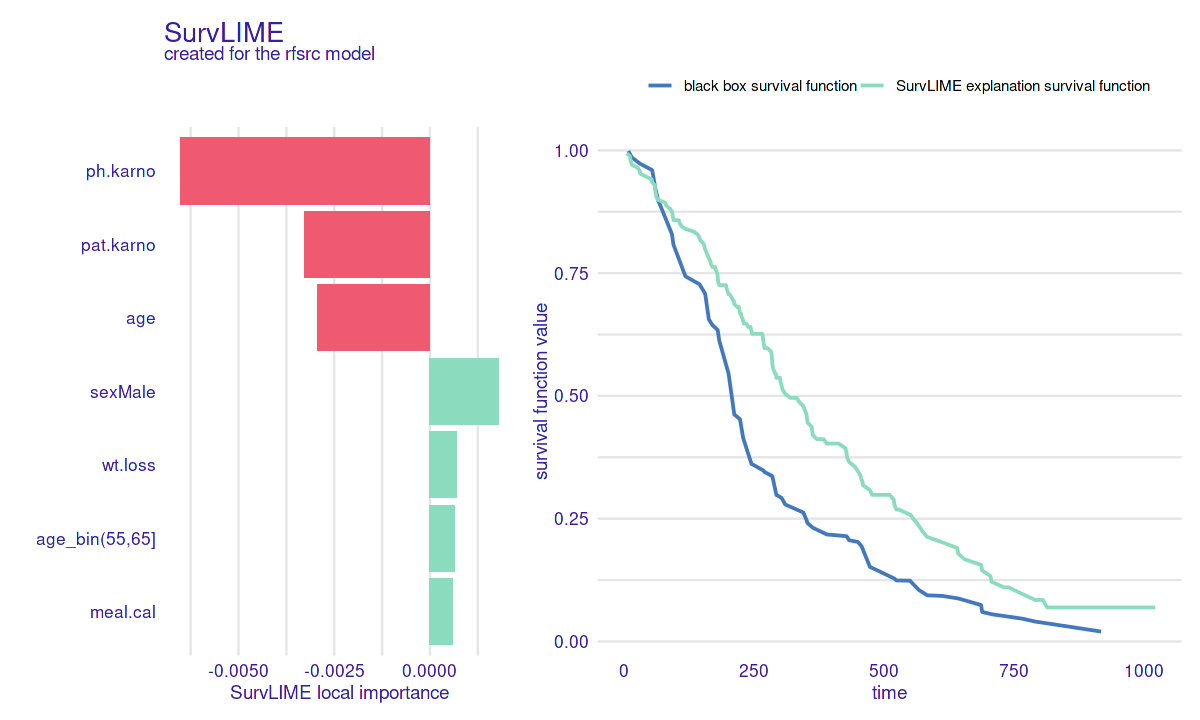

In [15]:
plot(surv_lime)

### Ceteris paribus profile
- Hold everything else equal, vary one variable, and plot the response.

In [16]:
p_profile <- predict_profile(explainer, d_lung[4,])

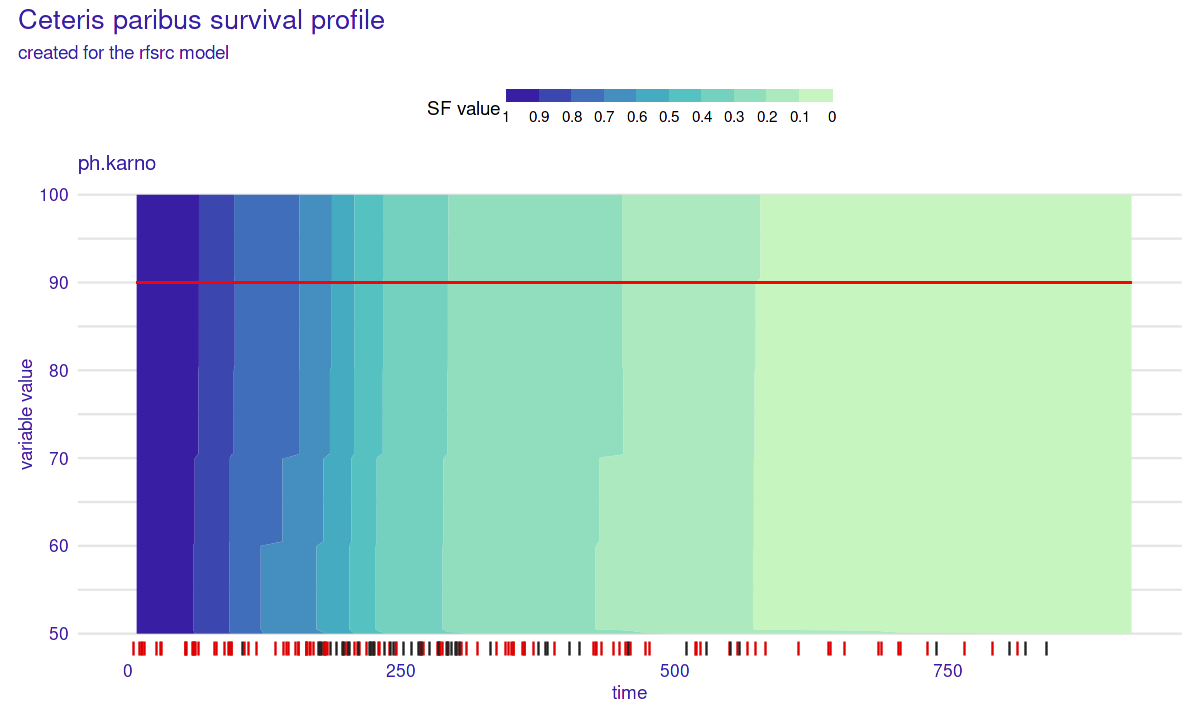

In [17]:
plot(p_profile, numerical_plot_type = "contours", variables = "ph.karno")

### Comparing model performance
- Example: compare RF model with CPH model.


In [18]:
library(survival)
cph_mdl <- d_lung %>% mutate(status = status - 1) %>% 
    select(-patient_id) %>% 
    coxph(Surv(time, status) ~ ., data = ., model=T, x=T)
summary(cph_mdl)

Call:
coxph(formula = Surv(time, status) ~ ., data = ., model = T, 
    x = T)

  n= 167, number of events= 120 
   (60 observations deleted due to missingness)

                        coef  exp(coef)   se(coef)      z Pr(>|z|)    
inst              -3.172e-02  9.688e-01  1.319e-02 -2.405 0.016181 *  
age                1.412e-02  1.014e+00  2.823e-02  0.500 0.617016    
sexFemale         -5.931e-01  5.526e-01  2.035e-01 -2.914 0.003565 ** 
ph.ecogAmbulatory  7.527e-01  2.123e+00  2.960e-01  2.543 0.010994 *  
ph.ecogBedridden   1.793e+00  6.010e+00  4.915e-01  3.649 0.000263 ***
ph.karno           2.635e-02  1.027e+00  1.188e-02  2.218 0.026572 *  
pat.karno         -8.876e-03  9.912e-01  8.590e-03 -1.033 0.301480    
meal.cal           2.117e-06  1.000e+00  2.682e-04  0.008 0.993703    
wt.loss           -1.521e-02  9.849e-01  8.047e-03 -1.890 0.058787 .  
age_bin(55,65]    -2.943e-01  7.450e-01  4.292e-01 -0.686 0.492823    
age_bin(65,83]    -1.030e-01  9.021e-01  6.579e-01 -0.157

In [19]:
m_perf <- model_performance(explainer)
cph_perf <- model_performance(explain(cph_mdl))

Preparation of a new explainer is initiated 
  -> model label       :  coxph (  default  ) 
  -> data              :  167  rows  9  cols (  extracted from the model  ) 
  -> target variable   :  167  values ( 120 events and 47 censored , censoring rate = 0.281 ) (  extracted from the model  ) 
  -> times             :  50 unique time points , min = 8 , median survival time = 310 , max = 918 
  -> times             :  (  generated from y as uniformly distributed survival quantiles based on Kaplan-Meier estimator  ) 
  -> predict function  :  predict.coxph with type = 'risk' will be used (  default  ) 
  -> predict survival function  :  predictSurvProb.coxph will be used (  default  ) 
  -> predict cumulative hazard function  :  -log(predict_survival_function) will be used (  default  ) 
  -> model_info        :  package survival , ver. 3.2.13 , task survival (  default  ) 
  A new explainer has been created!  


Warning message in .recacheSubclasses(def@className, def, env):
“undefined subclass "numericVector" of class "Mnumeric"; definition not updated”


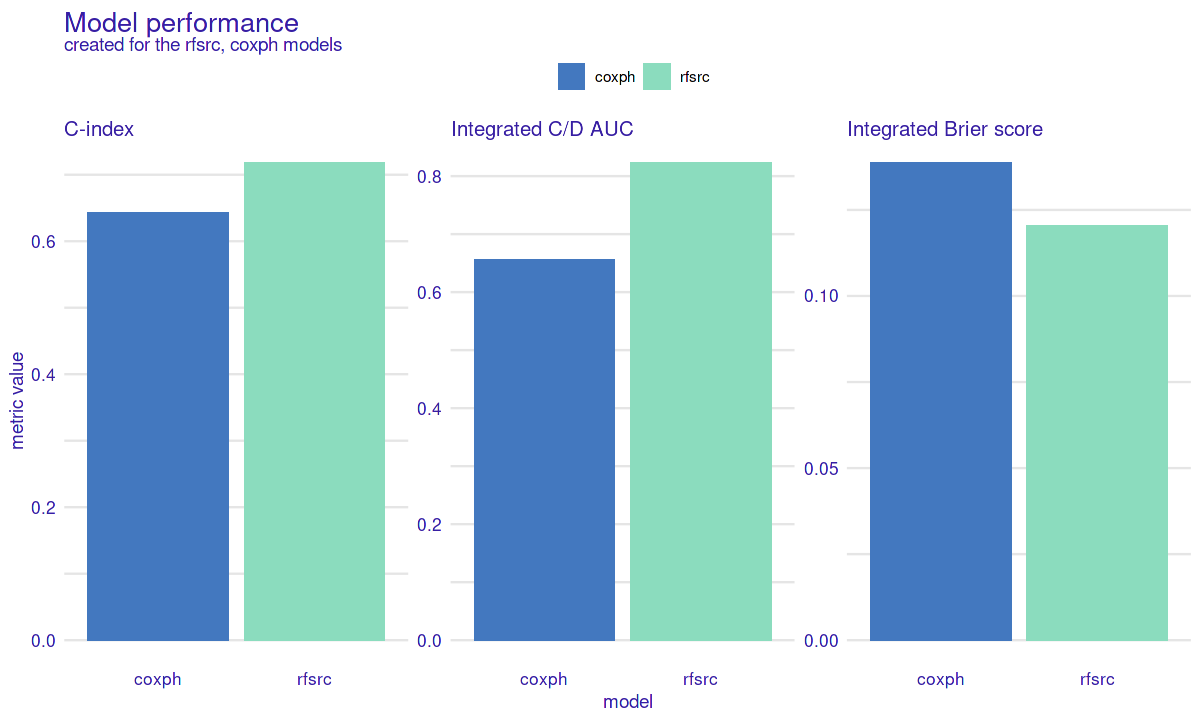

In [20]:
plot(m_perf, cph_perf, metrics_type = "scalar")

## Returning to the BHHT data

### BHHT data

- The full BHHT dataset is uploaded to the course website.
- (A reduced version containing ~10,000~ 10% randomly sampled rows is posted to the Github.)

In [21]:
u <- 'https://github.com/terhorst/stats504/raw/main/lectures/week13/bhht.RData'
load(url(u))
bhht %>% head

wikidata_code,birth,death,updated_death_date,approx_birth,approx_death,birth_min,birth_max,death_min,death_max,⋯,area2_of_rattachment,list_wikipedia_editions,un_region,group_wikipedia_editions,bplo1,dplo1,bpla1,dpla1,pantheon_1,level3_all_occ
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Q968005,1813,1866,NA,NA,NA,1813,1813,1866,1866,⋯,Missing,ptwiki|eswiki|enwiki|cawiki,America,grA,NA,NA,NA,NA,0,D:_writer_P:_ writer_English_gobierno_paisaje_poeta_Spanish_ poeta_Portuguese
Q5214096,1963,NA,NA,NA,NA,1963,1963,NA,NA,⋯,Missing,enwiki,America,grA,-79.38667,NA,43.67028,NA,0,D:_politician_P:_politician_conservative_legislative_English
Q8053113,1985,NA,NA,NA,NA,1985,1985,NA,NA,⋯,Missing,enwiki|tgwiki,Europe,grA,92.87195,NA,56.00889,NA,0,D:_football_P:_football_player_English
Q2987284,1632,1690,NA,NA,NA,1632,1632,1690,1690,⋯,Missing,be_x_oldwiki|plwiki|bewiki|ruwiki|enwiki|ltwiki|ukwiki,Europe,grA,NA,24.17220,NA,54.35000,0,D:_P:_noble_militar_commander_English
Q50807263,1925,2010,NA,NA,NA,1925,1925,2010,2010,⋯,Missing,itwiki,Europe,grB,14.25000,12.48278,40.83333,41.89305,0,D:_architect_P:_architetto_Italian
Q5136052,1923,1993,NA,NA,NA,1923,1923,1993,1993,⋯,Missing,enwiki,America,grA,-98.12030,-96.81310,31.70330,33.14140,0,D:_football_P:_football_player_business_English


### How has lifespan varied by decade in which you were born?

In [22]:
## Lifespan by decade
decades <- seq(-2500, 2500, 10)
bhht %>% 
    filter(birth > 0) %>% 
    mutate(death = ifelse(is.na(death), death_estimation, death)) %>% 
    mutate(bdec = cut(birth, decades, labels=tail(decades, -1)), lspan = death - birth) %>% 
    group_by(bdec) %>%
    summarize(mlspan = mean(lspan, na.rm = T), 
              sem = sd(lspan, na.rm = T) / sqrt(n())) ->
    lspan_plot

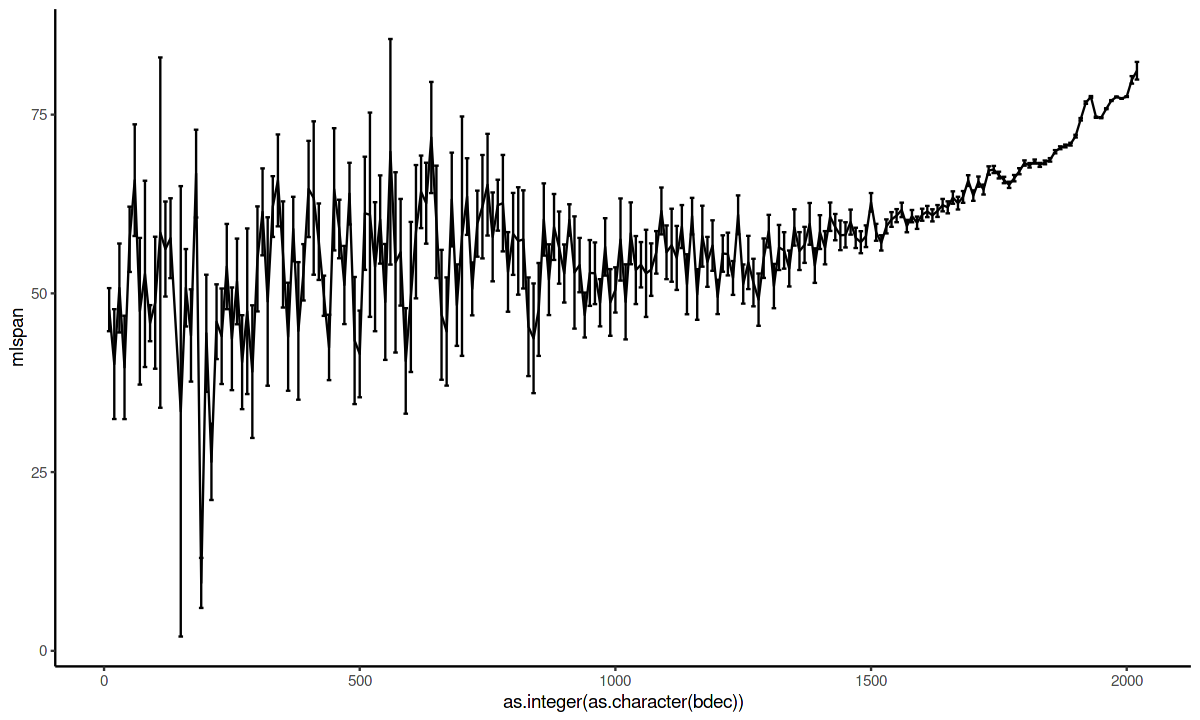

In [23]:
ggplot(lspan_plot, aes(x = as.integer(as.character(bdec)), y = mlspan)) + 
    geom_line() +
    geom_errorbar(aes(ymin = mlspan - sem, ymax = mlspan + sem))

### How does this compare to other published lifespan estimates?

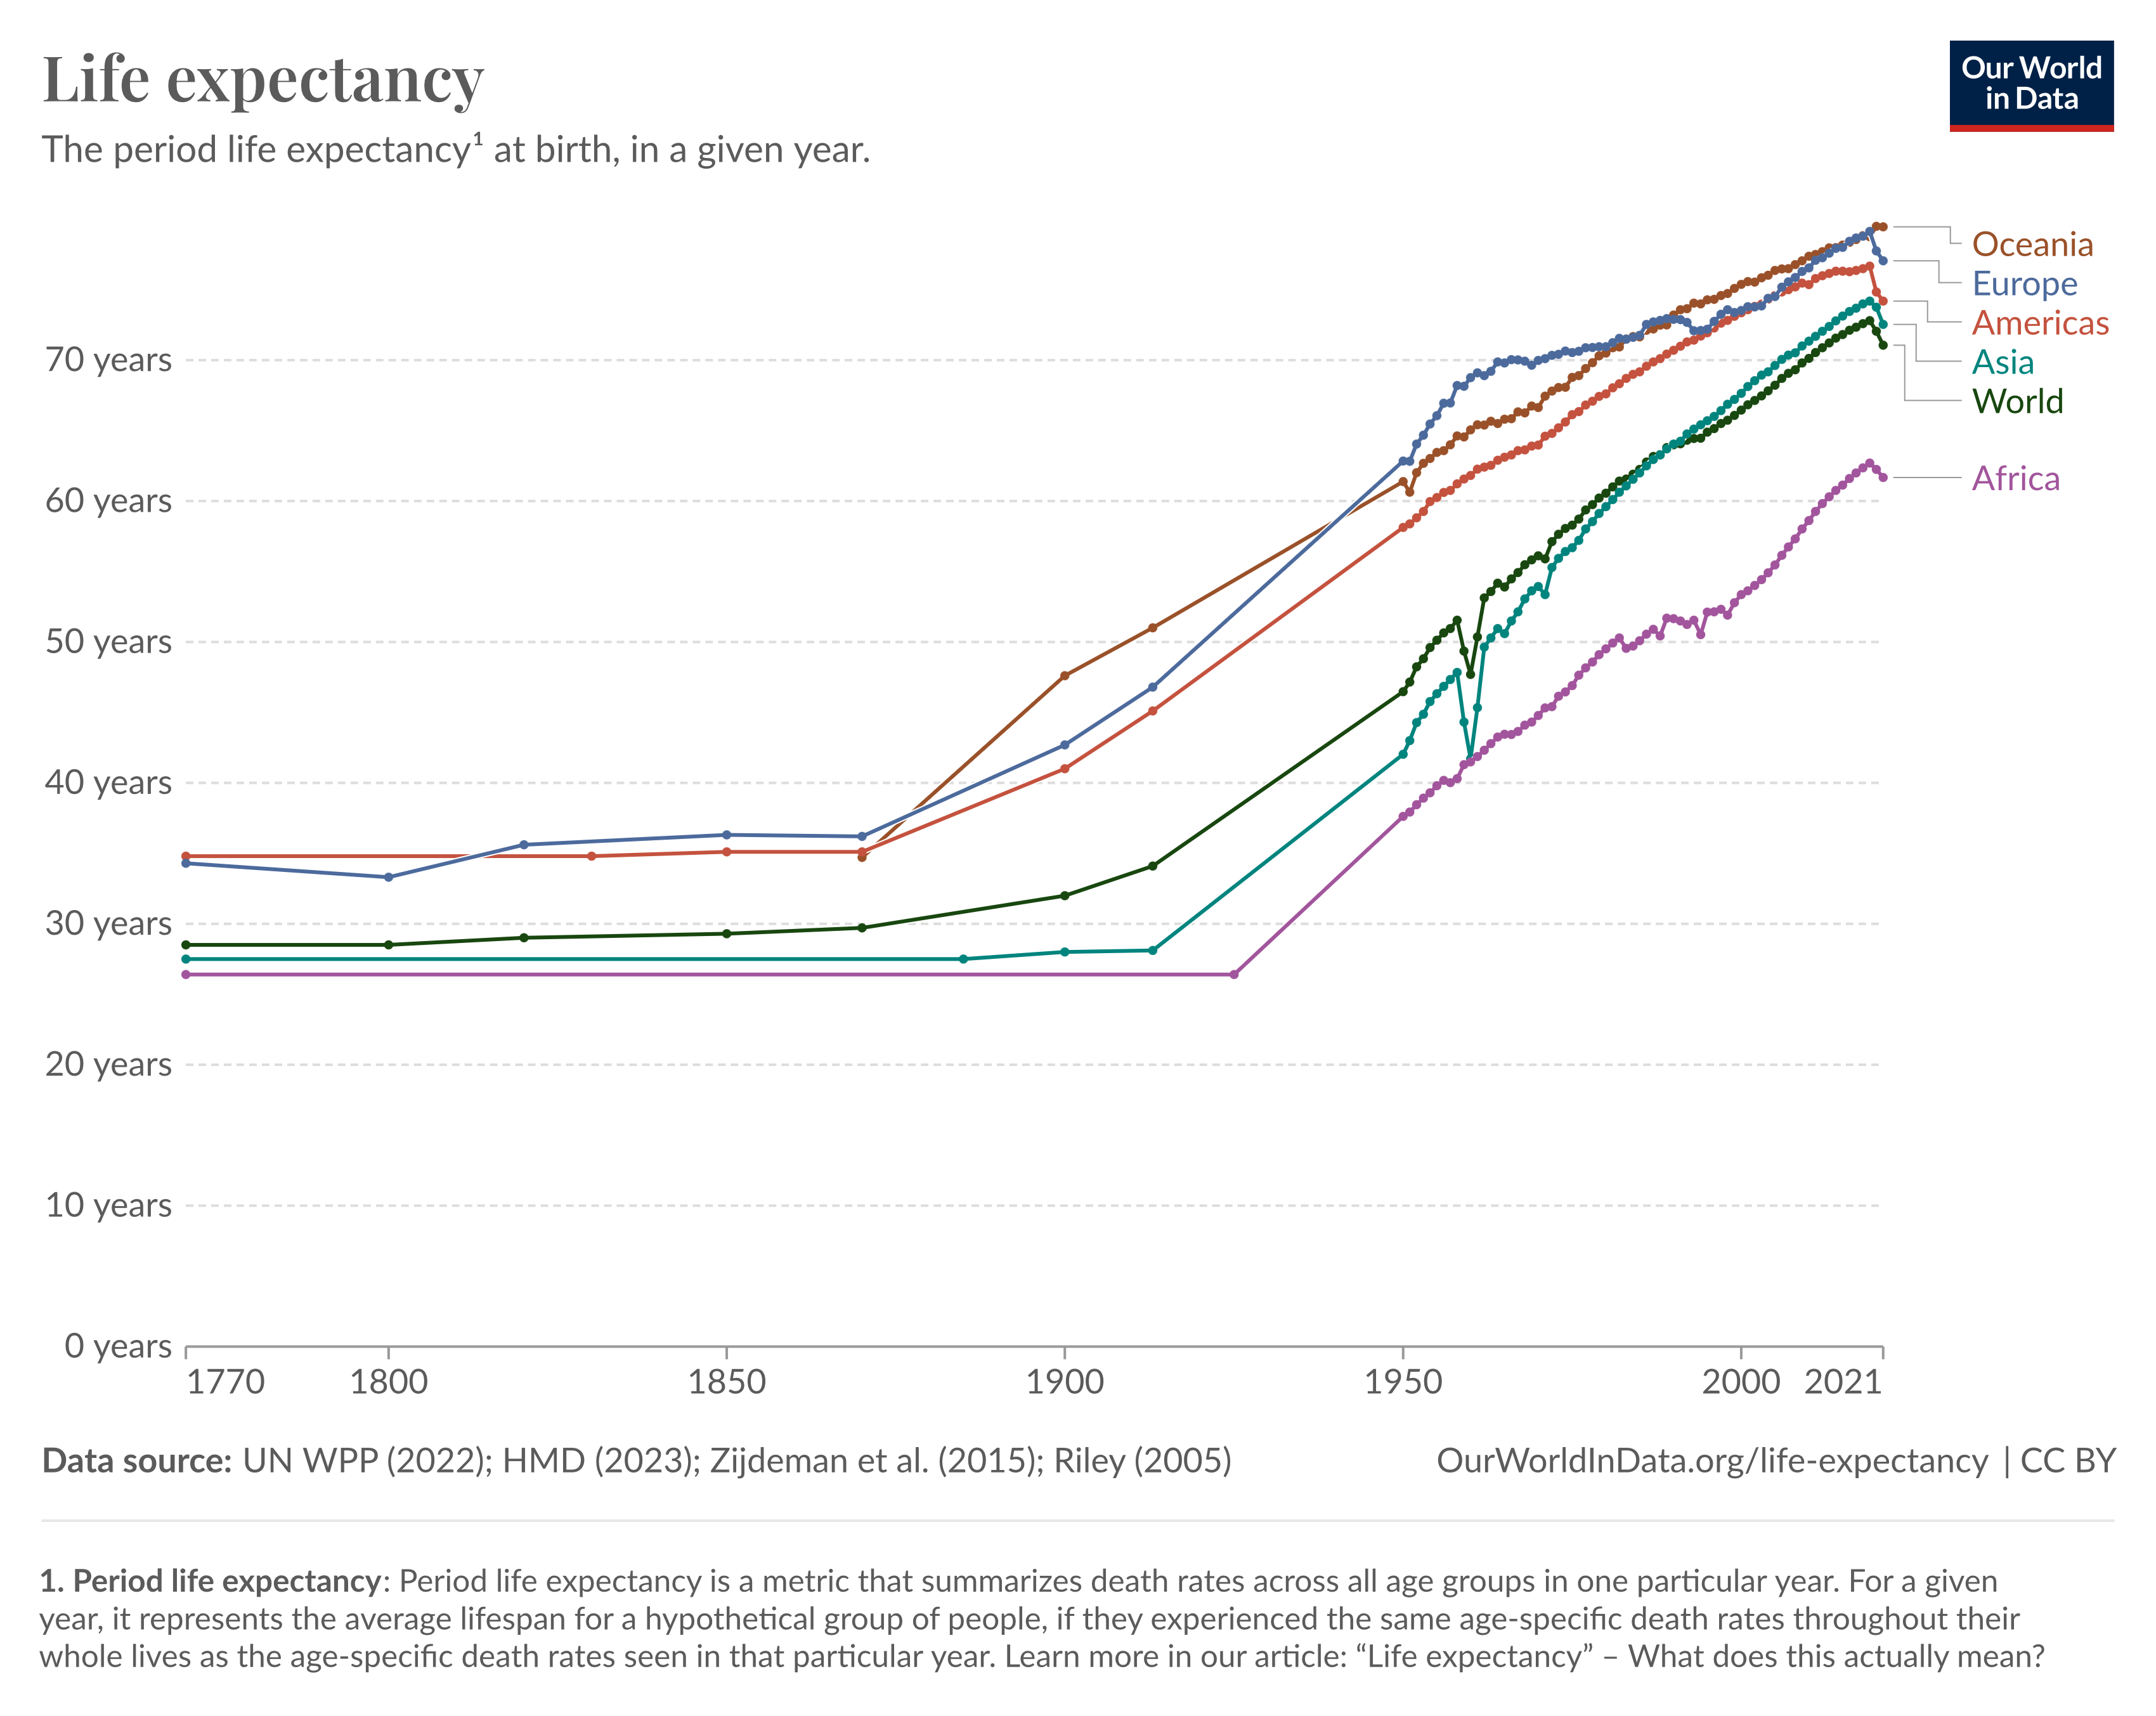

### Are these estimates affected by child mortality?
- How can we quantify presence of child mortality in the data?

In [41]:
# solution

### The life spans of various professions


In [24]:
table(bhht$level2_main_occ)


                            Academia                   Administration/Law 
                               25282                                 7624 
Corporate/Executive/Business (large)                         Culture-core 
                                4669                                60378 
                   Culture-periphery          Explorer/Inventor/Developer 
                                9741                                 2288 
                              Family                             Military 
                                1150                                 7201 
                             Missing                             Nobility 
                                1490                                 3688 
                               Other                             Politics 
                                1414                                31268 
                           Religious                         Sports/Games 
                        

`summarise()` has grouped output by 'bdec'. You can override using the `.groups` argument.


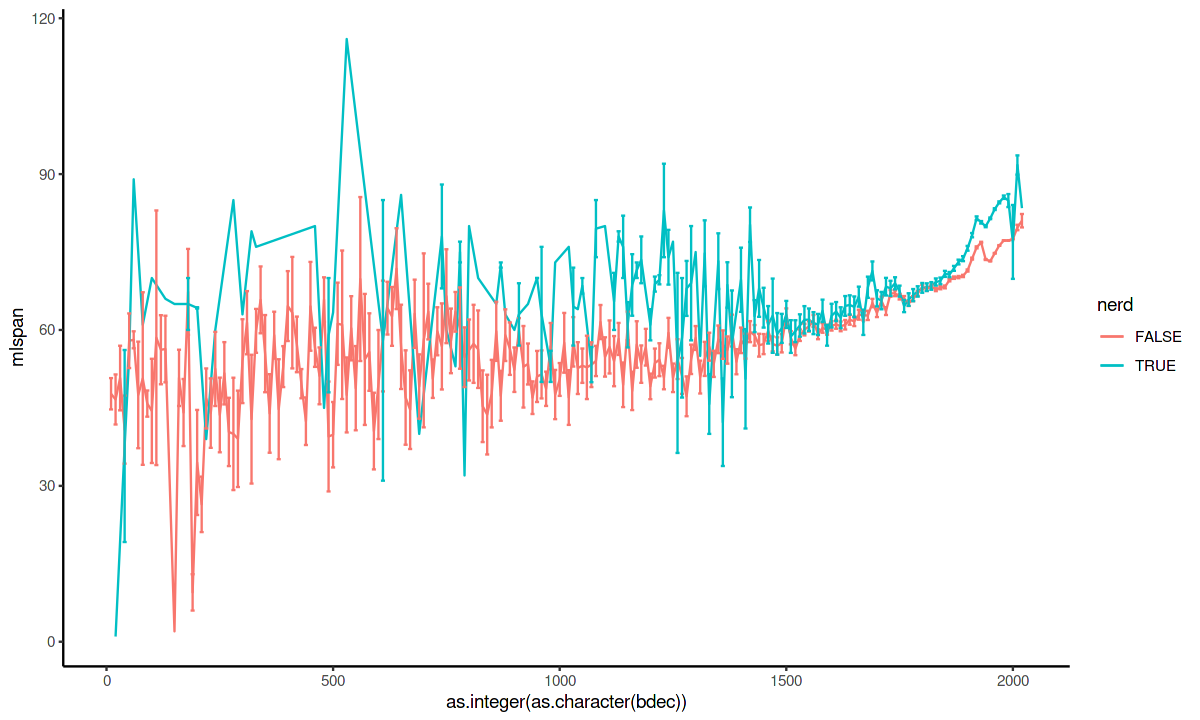

In [25]:
decades <- seq(-2500, 2500, 10)
bhht %>%
    mutate(nerd = level2_main_occ == "Academia") %>% 
    filter(birth > 0) %>% 
    mutate(death = ifelse(is.na(death), death_estimation, death)) %>% 
    mutate(bdec = cut(birth, decades, labels=tail(decades, -1)), lspan = death - birth) %>% 
    group_by(bdec, nerd) %>%
    summarize(mlspan = mean(lspan, na.rm = T), 
              sem = sd(lspan, na.rm = T) / sqrt(n())) %>% 
    ggplot(aes(x = as.integer(as.character(bdec)), y = mlspan, group = nerd, color = nerd)) + 
    geom_line() +
    geom_errorbar(aes(ymin = mlspan - sem, ymax = mlspan + sem))

### What is the effect of being an academic on lifespan?



In [26]:
library(survival)
bhht %>%
    mutate(nerd = level2_main_occ == "Academia") %>% 
    mutate(event = ifelse(is.na(death), death_estimation < 2024, T),
           time = pmin(death_estimation, 2024) - birth) ->
    bhht_lspan

In [27]:
mdl <- coxph(Surv(time, event) ~ nerd, data = bhht_lspan, model = T, x = T)
summary(mdl)

Call:
coxph(formula = Surv(time, event) ~ nerd, data = bhht_lspan, 
    model = T, x = T)

  n= 209693, number of events= 120423 
   (19489 observations deleted due to missingness)

             coef exp(coef) se(coef)      z Pr(>|z|)    
nerdTRUE -0.31089   0.73280  0.00846 -36.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         exp(coef) exp(-coef) lower .95 upper .95
nerdTRUE    0.7328      1.365    0.7207     0.745

Concordance= 0.522  (se = 0.001 )
Likelihood ratio test= 1454  on 1 df,   p=<2e-16
Wald test            = 1350  on 1 df,   p=<2e-16
Score (logrank) test = 1361  on 1 df,   p=<2e-16


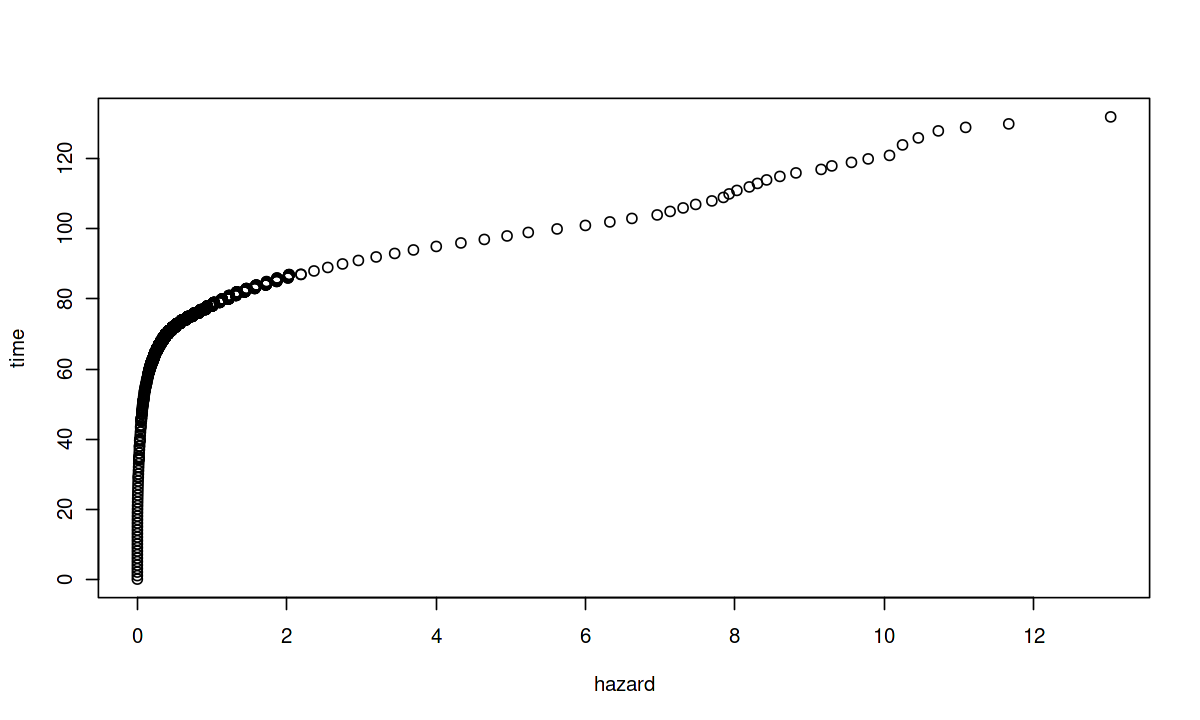

In [28]:
basehaz(mdl) %>% plot

### What is the effect of being nobility on lifespan?

- I want to quantify the effect of being a nobleperson on lifespan.

In [39]:
# solution (regression)

In [ ]:
# solution (survival)

### What was the most dangerous occupation within each time period?

- How to answer? (What metric to consider?)

In [30]:
table(bhht_lspan$bigperiod_birth)


     1.Ancient History Before 500AD 2.Post-Classical History 501-1500AD 
                                554                                3153 
  3.Early Modern Period 1501-1750AD     4.Mid Modern Period 1751-1900AD 
                               9397                               48141 
  5.Contemporary period 1901-2020AD                             Missing 
                             148448                               19489 

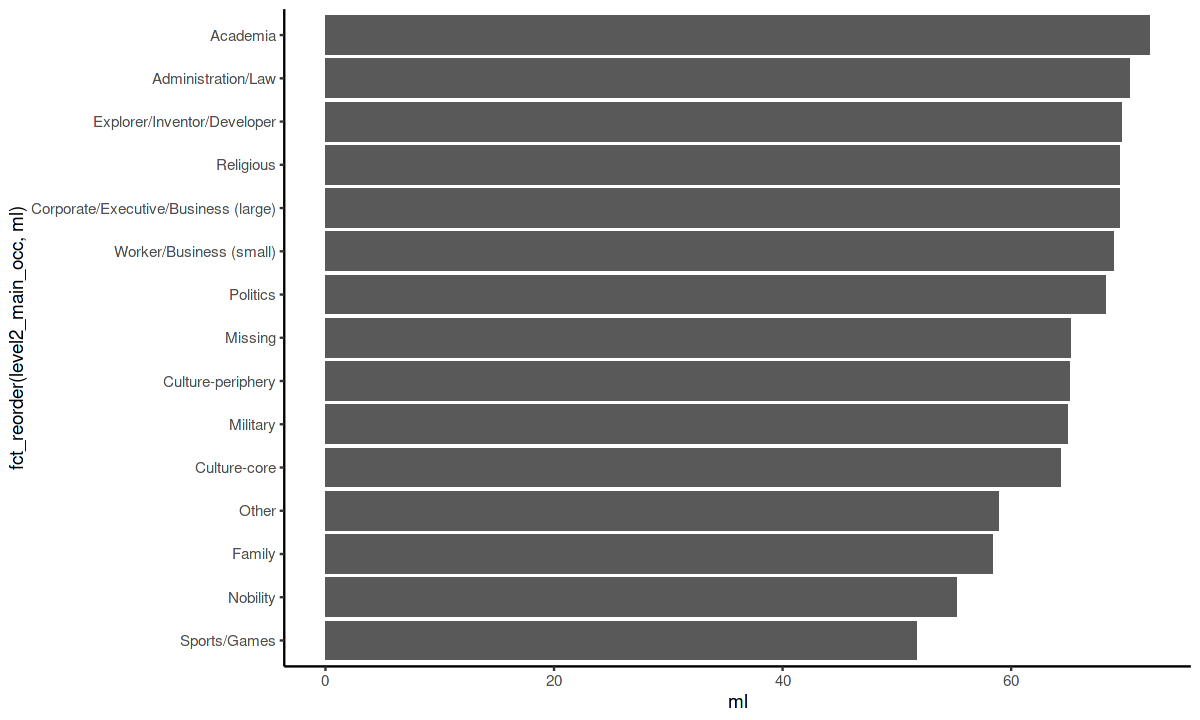

In [31]:
bhht_lspan %>% group_by(level2_main_occ) %>% 
    summarize(ml = mean(time, na.rm = T)) %>% 
    ggplot(aes(x = fct_reorder(level2_main_occ, ml), y = ml)) + geom_col() +
    coord_flip()

Can we model the effect of occupation on survival?

In [ ]:
# model survival effect on occupation

### What decades had abnormally high deaths?

- I want to generate a data frame that has one row per decade, columns for recorded # of births, and recorded # of deaths.

In [38]:
# solution

### Influence of variables on survival

- (Currently crashes my machine)

In [29]:
bhht

[1] "wikidata_code"            "birth"                   
 [3] "death"                    "updated_death_date"      
 [5] "approx_birth"             "approx_death"            
 [7] "birth_min"                "birth_max"               
 [9] "death_min"                "death_max"               
[11] "gender"                   "level1_main_occ"         
[13] "name"                     "un_subregion"            
[15] "birth_estimation"         "death_estimation"        
[17] "bigperiod_birth_graph_b"  "bigperiod_death_graph_b" 
[19] "curid"                    "level2_main_occ"         
[21] "freq_main_occ"            "freq_second_occ"         
[23] "level2_second_occ"        "level3_main_occ"         
[25] "bigperiod_birth"          "bigperiod_death"         
[27] "wiki_readers_2015_2018"   "non_missing_score"       
[29] "total_count_words_b"      "number_wiki_editions"    
[31] "total_noccur_links_b"     "sum_visib_ln_5criteria"  
[33] "ranking_visib_5criteria"  "all_geography_groups"    
[35] "string_citizenship_raw_d" "citizenship_1_b"         
[37] "citizenship_2_b"          "list_areas_of_rattach"   
[39] "area1_of_rattachment"     "area2_of_rattachment"    
[41] "list_wikipedia_editions"  "un_region"               
[43] "group_wikipedia_editions" "bplo1"                   
[45] "dplo1"                    "bpla1"                   
[47] "dpla1"                    "pantheon_1"              
[49] "level3_all_occ"           "nerd"                    
[51] "event"                    "time"

In [33]:
bhht_rf_df <- mutate(bhht_lspan, across(c(gender, level2_main_occ, un_subregion), as.factor)) %>% 
    select(time, event, gender, level2_main_occ, un_subregion)

bhht_rf_df <- bhht_rf_df[complete.cases(bhht_rf_df),]

In [ ]:
rf_bhht <- rfsrc(Surv(time, event) ~ gender + level2_main_occ + un_subregion, data = bhht_rf_df)